In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [112]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [113]:
def prepare_data(ticker):
    stock_price = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()
    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    
    stock_news = pd.read_csv(f"../dataset/polygon_title_sentiment_3/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date

    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = 0.0
    stock_news['pos_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_score'] = 0.0
    stock_news['neg_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_mean'] = np.nan
    stock_news['pos_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_mean'] = np.nan

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [sentiment_transform(['positive']), sentiment_transform(['negative'])], 
        'pos_score': 'mean', 'neg_score': 'mean', 'pos_mean': 'mean', 'neg_mean': 'mean'
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 'positive', 'negative', 
                           'pos_score', 'neg_score', 'pos_mean', 'neg_mean']
    return relation_gp

In [ ]:
relation_gp = prepare_data(ticker='MSFT')
relation_gp_t = relation_gp[relation_gp['negative'] > 0]
len(relation_gp_t), len(relation_gp)

/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_2169/2186838793.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return series.isin(label).sum() / series.count()


(440, 502)

In [115]:
def test_relevance(cols):
    X, y = relation_gp_t[cols], relation_gp_t['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [116]:
test_relevance(['negative'])

(6.907488271680408, 0.02756702146142387, array([-3.69707584]))

In [117]:
test_relevance(['neg_score'])

(6.88713177514832, 0.030432799552783996, array([4.37935476]))

In [118]:
test_relevance(['neg_mean'])

(7.02695332925326, 0.010748786352269057, array([2.14164812]))

In [119]:
test_relevance(['negative', 'neg_mean'])

(6.865974333038661, 0.03341133438914479, array([-3.40207095,  1.6027312 ]))

In [120]:
test_relevance(['positive', 'negative'])

(6.811820020345246, 0.04103515328277496, array([ 2.30858595, -2.86301241]))

In [121]:
test_relevance(['positive', 'negative', 'neg_mean'])

(6.758096762719858,
 0.048598288444891224,
 array([ 2.46096793, -2.47106594,  1.83030361]))

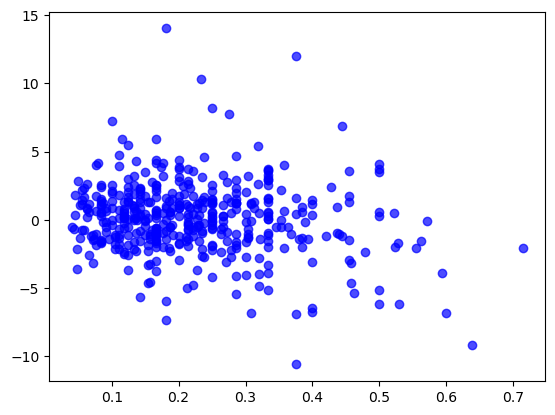

In [122]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp_t['negative'], relation_gp_t['delta'], color='blue', alpha=0.7)

In [123]:
def preprocess(relation_gp, feat_cols):
    seq_length = 10
    std_scaler = StandardScaler()
    df = pd.DataFrame()
    df[feat_cols] = std_scaler.fit_transform(relation_gp[feat_cols])

    X = []
    y = []
    for i in range(seq_length, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = np.array(X)
    y = np.array(y)

    split_index = int(len(X) * 0.95)
    X, X_test = X[:split_index], X[split_index:]
    y, y_test = y[:split_index], y[split_index:]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=67)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
    y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1) 
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) 

    return X_train, X_val, X_test, y_train, y_val, y_test

In [124]:
class SimpleLSTM(nn.Module):
    def __init__(self, feat_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.fc1 = nn.Linear(feat_size[0], feat_size[1])
        self.lstm = nn.LSTM(feat_size[1], feat_size[2], num_layers=layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(feat_size[2], feat_size[3])
    
    def forward(self, x):
        inp = self.fc1(x)
        lstm_out, (hn, cn) = self.lstm(inp)
        out = self.fc2(hn[-1])
        return out

In [125]:
feat_cols = ['neg_score', 'close']
model = SimpleLSTM(feat_size=[len(feat_cols), 16, 64, 1], layers=2, dropout=0.5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(relation_gp, feat_cols)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([443, 10, 2]),
 torch.Size([24, 10, 2]),
 torch.Size([25, 10, 2]),
 torch.Size([443, 1]),
 torch.Size([24, 1]),
 torch.Size([25, 1]))

In [126]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

Epoch 1, Train Loss: 0.8577, Test Loss: 2.9160
Epoch 2, Train Loss: 0.8239, Test Loss: 2.8735
Epoch 3, Train Loss: 0.7917, Test Loss: 2.8221
Epoch 4, Train Loss: 0.7553, Test Loss: 2.7597
Epoch 5, Train Loss: 0.7197, Test Loss: 2.6844
Epoch 6, Train Loss: 0.6785, Test Loss: 2.5944
Epoch 7, Train Loss: 0.6368, Test Loss: 2.4879
Epoch 8, Train Loss: 0.5876, Test Loss: 2.3637
Epoch 9, Train Loss: 0.5357, Test Loss: 2.2210
Epoch 10, Train Loss: 0.4799, Test Loss: 2.0600
Epoch 11, Train Loss: 0.4234, Test Loss: 1.8824
Epoch 12, Train Loss: 0.3617, Test Loss: 1.6910
Epoch 13, Train Loss: 0.3018, Test Loss: 1.4910
Epoch 14, Train Loss: 0.2488, Test Loss: 1.2886
Epoch 15, Train Loss: 0.2042, Test Loss: 1.0901
Epoch 16, Train Loss: 0.1691, Test Loss: 0.9008
Epoch 17, Train Loss: 0.1463, Test Loss: 0.7245
Epoch 18, Train Loss: 0.1373, Test Loss: 0.5648
Epoch 19, Train Loss: 0.1306, Test Loss: 0.4255
Epoch 20, Train Loss: 0.1349, Test Loss: 0.3115
Epoch 21, Train Loss: 0.1397, Test Loss: 0.2270
E

In [127]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Test Loss: 0.0116
Std: 0.1417
Error Range: 0.7596
